In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

# NOTE: I am ignoring the deprecation warnings on lmafit because I haven't found a way around them yet
warnings.filterwarnings("ignore")

cwd = os.getcwd()
par = os.path.join(cwd, os.pardir)
sys.path.append(par)

# I made some modules to make importing easier and to have a nice class
# that does all the matrix operations
import matrix_operation
import Dataset

In [2]:
# Just to reload the modules I imported above so I dont need to restart the kernel after making changes
import importlib
importlib.reload(matrix_operation)
importlib.reload(Dataset)

from matrix_operation import mat_opr
from Dataset import dataset

### Import and combine NYT and Big10

In [3]:
# hopefully this works on with your directory structure
# dset.nyt_df : NYT data
# dset.big10_df : Big10 data
# dset.combined and dset.dataframe are the combined version
dset = dataset()

# drop all zero rows and columns
dset.drop_zero_rows()
dset.drop_zero_cols()

# drop all rows where Big10 isn't complete
dset = dset.drop_bad_rows()

### Check the SVD to see whats going on with the rank:

In [4]:
np.linalg.matrix_rank(dset.array)

27

96 singular values (the matrix is 96 x 1872)


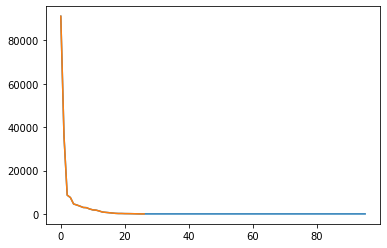

In [5]:
u, s, vt  = np.linalg.svd(dset.array)
print(str(s.shape[0]) + " singular values (the matrix is " + str(len(dset.array)) + " x " + str(len(dset.array[0])) + ")")
plt.plot(range(len(s)),s)

# The first 28 values are the only ones that aren't tiny numbers -- effective rank of 28?

plt.plot(range(27),s[:27])

#print(s[:28])

### Calculate rank approximation 

In [6]:
def rank_approx(data_obj):
    u,s,vt = np.linalg.svd(dset.array)
    denom = 0
    for i in s:
        denom += i**2

    numer = 0
    ratio = 0
    ranker = 0
    while ratio < 0.8:
        numer += s[ranker]**2
        ratio = numer/denom
        
        print(ratio)
        ranker += 1

    print("rank approx: " + str(ranker))
    return ranker

In [7]:
ranker = rank_approx(dset)

0.8468998037420391
rank approx: 1


## Compare inputs and output after lmafit + isotonic regression

In [8]:
inp = dset.dataframe

# Matrix completion
X,Y,oth = dset.lmafitter(rank = ranker, val = 0)
comp = pd.DataFrame(np.dot(X,Y))

pre_iso = comp
pre_iso.columns = inp.columns
pre_iso.index = inp.index

# Isotonic regression
comp = mat_opr(comp)
iso = comp.known_iso()
out = iso.dataframe

### Big 10 Schools

<AxesSubplot:title={'center':'Iowa'}>

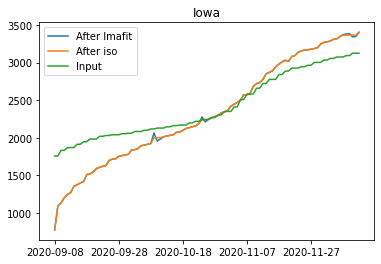

In [9]:
Iowa = pd.concat([inp['Iowa'], pre_iso['Iowa'], out['Iowa']], axis = 1)
Iowa.columns = ['Input', 'After lmafit', 'After iso']
Iowa = Iowa.replace(0,np.nan)

Iowa.drop('Input',1).plot(kind = 'line',legend=True, title = 'Iowa')
Iowa['Input'].plot(legend=True)

<AxesSubplot:title={'center':'Michigan State'}>

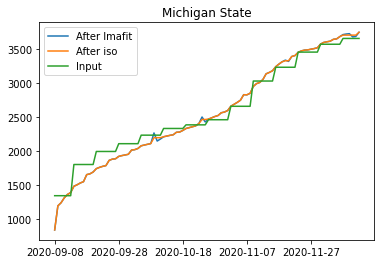

In [10]:
Michigan = pd.concat([inp['Michigan State'], pre_iso['Michigan State'], out['Michigan State']], axis = 1)
Michigan.columns = ['Input', 'After lmafit', 'After iso']
Michigan = Michigan.replace(0,np.nan)

Michigan.drop('Input',1).plot(kind = 'line',legend=True, title = 'Michigan State')
Michigan['Input'].plot(legend=True)

<AxesSubplot:title={'center':'Ohio State'}>

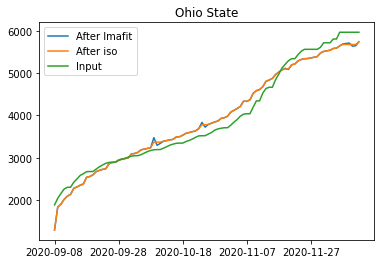

In [11]:
Ohio = pd.concat([inp['Ohio State'], pre_iso['Ohio State'], out['Ohio State']], axis = 1)
Ohio.columns = ['Input', 'After lmafit', 'After iso']
Ohio = Ohio.replace(0,np.nan)

Ohio.drop('Input',1).plot(kind = 'line',legend=True, title = 'Ohio State')
Ohio['Input'].plot(legend=True)

### NYT Schools

<AxesSubplot:title={'center':'Boston University'}>

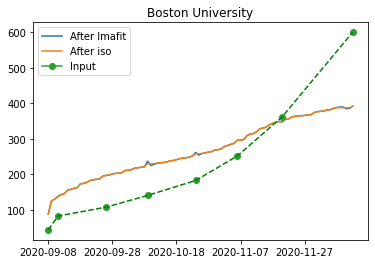

In [12]:
bu = pd.concat([inp['Boston University'], pre_iso['Boston University'], out['Boston University']], axis = 1)
bu.columns = ['Input','After lmafit', 'After iso']
bu = bu.replace(0,np.nan)

bu.drop('Input',1).plot(kind = 'line',legend=True, title = 'Boston University')
bu['Input'].plot(marker='o',legend=True)
bu['Input'].interpolate(method='linear').plot(color = 'g', linestyle='--')

<AxesSubplot:title={'center':'University of California, Los Angeles'}>

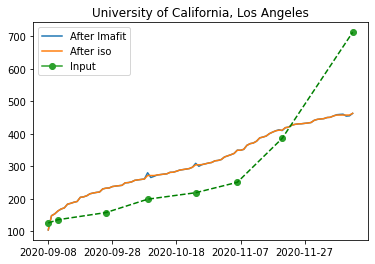

In [13]:
ucla = pd.concat([inp['University of California, Los Angeles'], pre_iso['University of California, Los Angeles'], out['University of California, Los Angeles']], axis = 1)
ucla.columns = ['Input','After lmafit', 'After iso']
ucla = ucla.replace(0,np.nan)

ucla.drop('Input',1).plot(kind = 'line',legend=True, title = 'University of California, Los Angeles')
ucla['Input'].plot(marker='o', legend = True)
ucla['Input'].interpolate(method='linear').plot(color = 'g', linestyle='--')

<AxesSubplot:title={'center':'Florida State University'}>

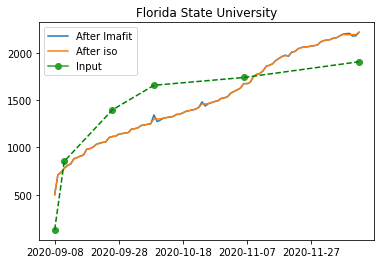

In [14]:
florida = pd.concat([inp['Florida State University'], pre_iso['Florida State University'], out['Florida State University']], axis = 1)
florida.columns = ['Input', 'After lmafit', 'After iso']
florida = florida.replace(0,np.nan)

florida.drop('Input',1).plot(kind = 'line',legend=True, title = 'Florida State University')
florida['Input'].plot(marker='o',legend=True)
florida['Input'].interpolate(method='linear').plot(color = 'g', linestyle='--')

### Randomly Hide entries and compute error

In [15]:
def error(hidden_vals, newframe):
    # hidden_vals is a dictionary with structure {(x,y): value}
    # new frame is the dataframe after doing matrix completion etc.
    
    # Keeping things simple by doing mean absolute error for now
    summ = 0
    for h in hidden_vals.keys():
        frame_val = newframe.iloc[h[0],h[1]]
        if frame_val is None or np.isnan(frame_val):
            frame_val = 0
        err = abs(frame_val - hidden_vals[h])
        summ += err
        
    mean_absolute = summ/len(hidden_vals)
    
    #print("The computed matrix has an average error of " + str(mean_absolute))
    #print()
    return mean_absolute
        
        

In [16]:
# make sure error is working correctly by passing it the original matrix
# Should get an error of 0

orig_vals = {}
for row in range(len(dset.array)):
    for col in range(len(dset.array[row])):
        orig_vals[(row, col)] = dset.array[row][col]
        
print(error(orig_vals, dset.dataframe))
        

0.0


In [17]:
def hider(obj, trials = [], isotonic = False):
    # trials should be a list of percents [0.33, 0.25, ...] corresponding to how much data is hidden
    trials.sort()
    complete_results = []
    iso_results = []
    ranky = obj.rank_approx()
    for i in trials:
        # Make the new hidden matrix and record the values that were hidden
        hidden_matrix, hidden_values = obj.hide_entries(i, 0)
        
        # Do lmafit
        X,Y,other = hidden_matrix.lmafitter(rank = ranky, val = 0)
        complete = pd.DataFrame(np.dot(X,Y))
        
        #print("With " + str(i) + " percent hidden: ")
        #hidden_matrix.is_col_inc()
        
        # Optional: do isotonic regression
        if isotonic == True:
            iso_reg = mat_opr(complete).known_iso()
            complete_results.append(error(hidden_values, complete))
            iso_results.append(error(hidden_values, iso_reg.dataframe))
        else:
            complete_results.append(error(hidden_values, complete))
            
    return complete_results, iso_results
        

In [18]:
tests = np.linspace(0.1,1,10)

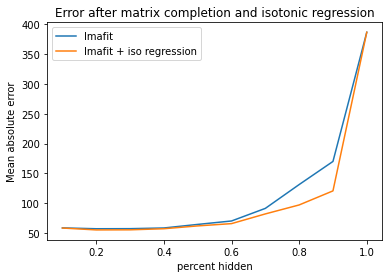

In [19]:
comp_err, iso_err = hider(dset, tests, True)

plt.plot(tests, comp_err, label="lmafit")
plt.plot(tests, iso_err, label="lmafit + iso regression")
plt.xlabel("percent hidden")
plt.ylabel("Mean absolute error")
plt.title("Error after matrix completion and isotonic regression")
plt.legend()

In [20]:
hid_mat, hid_val = dset.hide_entries(0, 0)
Xs, Ys, os = hid_mat.lmafitter(ranker)
eighty = pd.DataFrame(np.dot(Xs,Ys))
eighty.columns = hid_mat.dataframe.columns
eighty.index = hid_mat.dataframe.index
eighty_iso = mat_opr(eighty).known_iso()


<AxesSubplot:title={'center':'Boston University'}>

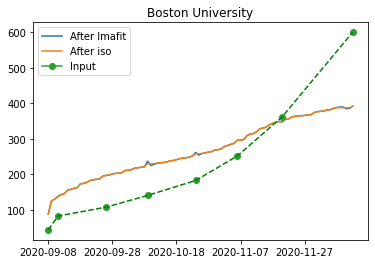

In [21]:
bu = pd.concat([inp['Boston University'], eighty['Boston University'], eighty_iso.dataframe['Boston University']], axis = 1)
bu.columns = ['Input', 'After lmafit', 'After iso']
bu = bu.replace(0,np.nan)

bu.drop('Input',1).plot(kind = 'line',legend=True, title = 'Boston University')
bu['Input'].plot(marker='o',legend=True)
bu['Input'].interpolate(method='linear').plot(color = 'g', linestyle='--')

## Experiment 1 -- Monotonicity 

In [22]:
# Check if the initial matrix is column increasing
# NOTE: this does not include points that are 0 or None
violation_dict, percent = dset.is_col_inc()
print(str(percent) + ' percent of the data points are non-increasing')

0.07066862535612536 percent of the data points are non-increasing


In [23]:
# do isotonic regression on the original matrix:
with_iso = dset.known_iso()

In [24]:
with_iso.is_col_inc()

({}, 0.0)

In [25]:
iso_ranker = with_iso.rank_approx()
print(iso_ranker)

1


In [26]:
np.linalg.matrix_rank(with_iso.array)

33

In [27]:
# run lmafit
X2, Y2, o2 = with_iso.lmafitter(iso_ranker)

dotted = pd.DataFrame(np.dot(X2, Y2))
dotted.columns = dset.dataframe.columns
dotted.index = dset.dataframe.index
with_comp = mat_opr(dotted)

In [28]:
none_hidden_dict, none_percent = with_comp.is_col_inc()
print(str(none_percent) + " percent of the data points are non-increasing")

5.208333333333334 percent of the data points are non-increasing


<AxesSubplot:title={'center':'Boston University'}>

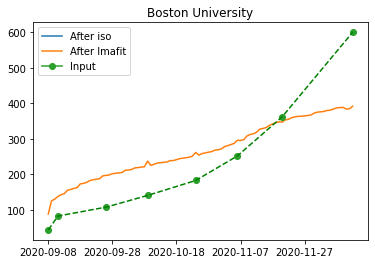

In [29]:
bu = pd.concat([inp['Boston University'], with_iso.dataframe['Boston University'], with_comp.dataframe['Boston University']], axis = 1)
bu.columns = ['Input', 'After iso', 'After lmafit']
bu = bu.replace(0,np.nan)

bu.drop('Input',1).plot(kind = 'line',legend=True, title = 'Boston University')
bu['Input'].plot(marker='o',legend=True)
bu['Input'].interpolate(method='linear').plot(color = 'g', linestyle='--')

<AxesSubplot:title={'center':'Xavier University'}>

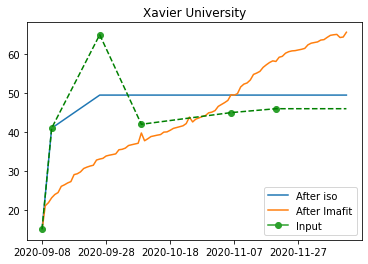

In [30]:
tt = pd.concat([inp['Xavier University'], with_iso.dataframe.iloc[:,23], with_comp.dataframe.iloc[:,23]], axis = 1)
tt.columns = ['Input', 'After iso', 'After lmafit']
tt = tt.replace(0,np.nan)

tt.drop('Input',1).plot(kind = 'line',legend=True, title = 'Xavier University')
tt['Input'].plot(marker='o',legend=True)
tt['Input'].interpolate(method='linear').plot(color = 'g', linestyle='--')

### Randomly hide rows

In [31]:
tests = [0, 0.05, 0.1, 0.2, 0.3, 0.4]
percent_violate = [0 for i in range(len(tests))]
percent_violate[0] = none_percent

In [32]:
for trial in range(10):
    for i in range(len(tests)):
        if i == 0:
            percent_violate[0] += none_percent
        else:
            hidden = with_iso.hide_rows(tests[i])

            X3, Y3, o3 = hidden.lmafitter(iso_ranker)

            dotted = pd.DataFrame(np.dot(X3, Y3))
            dotted.columns = hidden.dataframe.columns
            dotted.index = hidden.dataframe.index
            post_fit = mat_opr(dotted)

            post_dict, post_perc = post_fit.is_col_inc()
            percent_violate[i] += post_perc

### Randomly hide non-NYT rows

In [33]:
# drop any of the non-NYT dates
# to do so I need to find where they are:

def find_non_nyt(data_obj):
    listy = list(data_obj.dataframe.index)
    bigs = []
    for i in data_obj.dataframe.index:
        bigs.append((data_obj.dataframe.loc[i]!=0).sum())
        if (data_obj.dataframe.loc[i]!=0).sum() > 100:
            listy.remove(i)
    return listy

In [34]:
non_rand = find_non_nyt(dset)

In [35]:
violators = [0 for i in range(len(tests))]
violators[0] = none_percent

In [36]:
for trial in range(10):
    for i in range(len(tests)):
        if i == 0:
            violators[0] += none_percent
        else:
            hidden = with_iso.hide_rows(tests[i],non_rand)

            X4, Y4, o4 = hidden.lmafitter(1)

            dotted = pd.DataFrame(np.dot(X4, Y4))
            dotted.columns = hidden.dataframe.columns
            dotted.index = hidden.dataframe.index
            post_fit = mat_opr(dotted)

            post_dict, post_perc = post_fit.is_col_inc()
            violators[i] += post_perc

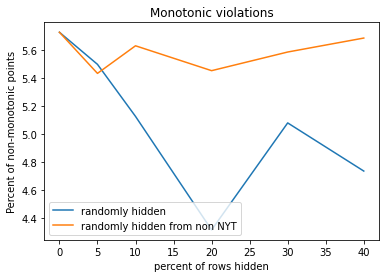

In [37]:
plt.plot([i*100 for i in tests], [j/10 for j in percent_violate], label = "randomly hidden")
plt.plot([i*100 for i in tests], [j/10 for j in violators], label="randomly hidden from non NYT")

plt.xlabel("percent of rows hidden")
plt.ylabel("Percent of non-monotonic points")
plt.title("Monotonic violations")
plt.legend()

In [38]:
with_hidden = with_iso.hide_rows(0.4, non_rand)

X5,Y5,o5 = with_hidden.lmafitter(iso_ranker)
tog = pd.DataFrame(np.dot(X5,Y5))
tog.columns = with_hidden.dataframe.columns
tog.index = with_hidden.dataframe.index
tofin = mat_opr(tog)


<AxesSubplot:title={'center':'Boston University'}>

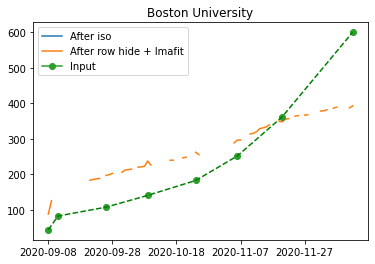

In [39]:
bu = pd.concat([dset.dataframe['Boston University'], with_iso.dataframe['Boston University'], tofin.dataframe['Boston University']], axis = 1)
bu.columns = ['Input', 'After iso', 'After row hide + lmafit']
bu = bu.replace(0,np.nan)

bu.drop('Input',1).plot(kind = 'line',legend=True, title = 'Boston University')
bu['Input'].plot(marker='o',legend=True)
bu['Input'].interpolate(method='linear').plot(color = 'g', linestyle='--')